# Taux d'occupation des salles, campus Lombarderie FST
## au 10/02/2020

## Définitions

In [1]:
# Bibliothèques
import ics
from ics import Calendar
import math
from datetime import date
import datetime

from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import widgets
from ipywidgets import interact

from IPython.display import FileLink,display

import pandas as pd
import json

# Configuration

annee = 2019

if annee == 2019:
    #2019
    reftimestamp = datetime.datetime(2019,8,26,0,0,0).timestamp() # = 26/8/2019 à 0h00m00
    passageheurehiverTS = datetime.datetime(2019,10,27,0,0,0).timestamp() # = 27/10/2019 à 0h00m00
    passageheureeteTS = datetime.datetime(2020,3,29,0,0,0).timestamp() 
else:
    #2018
    reftimestamp = datetime.datetime(2018,8,27,0,0,0).timestamp()
    passageheurehiverTS = datetime.datetime(2018,10,28,0,0,0).timestamp()
    passageheureeteTS = datetime.datetime(2019,31,29,0,0,0).timestamp() 

NbSemainesS1 = 13
NbSemainesS2 = 13
NbJoursparSemaine = 5
NbHeuresparJour = 8
T_inc = 10 # un point toutes les 1 minute(s)
TraitementOn=False
recuperationCal=False

# Quelques fonctions utiles

# Lecture d'un calendrier en mémoire
def readcal(filename):
    fd=open(filename,"r")
    content=""
    for l in fd:
        content=content+"\n"+l
    fd.close()
    cal=ics.Calendar(content)
    return cal

# récupération des fichiers sur CELCAT
def recuperationFichiers(annee):
    if annee == 2019:
        # Pour 2019 sur sciences-bis
        !curl https://edt.univ-nantes.fr/sciences/g355056.ics -o 2019_L1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355055.ics -o 2019_L2.ics
        !curl https://edt.univ-nantes.fr/sciences/g355687.ics -o 2019_L3.ics
        !curl https://edt.univ-nantes.fr/sciences/g355732.ics -o 2019_M1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355740.ics -o 2019_M2.ics
        !curl https://edt.univ-nantes.fr/sciences/g351309.ics -o 2019_TREMPLIN.ics
        !curl https://edt.univ-nantes.fr/sciences/g913556.ics -o 2019_ACCOMPLI.ics
        !curl https://edt.univ-nantes.fr/sciences/g918815.ics -o 2019_DUEIL.ics
        !curl https://edt.univ-nantes.fr/sciences/g351082.ics -o 2019_DUG.ics
        !curl https://edt.univ-nantes.fr/sciences/g351317.ics -o 2019_UED.ics
        !curl https://edt.univ-nantes.fr/sciences/g351316.ics -o 2019_TUTO.ics
        !curl https://edt.univ-nantes.fr/sciences/g355731.ics -o 2019_M1MEEF.ics
        !curl https://edt.univ-nantes.fr/sciences/g355738.ics -o 2019_M2MEEF.ics
    else:
        # Pour 2018 sur sciences (Plus d'acualité.... car 2019 est maintenant sur sciences)
        !curl https://edt.univ-nantes.fr/sciences/g355056.ics -o 2018_L1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355055.ics -o 2018_L2.ics
        !curl https://edt.univ-nantes.fr/sciences/g355687.ics -o 2018_L3.ics
        !curl https://edt.univ-nantes.fr/sciences/g355732.ics -o 2018_M1.ics
        !curl https://edt.univ-nantes.fr/sciences/g355740.ics -o 2018_M2.ics
        !curl https://edt.univ-nantes.fr/sciences/g351309.ics -o 2018_TREMPLIN.ics
        !curl https://edt.univ-nantes.fr/sciences/g522202.ics -o 2018_ACCOMPLI.ics
        !curl https://edt.univ-nantes.fr/sciences/g918815.ics -o 2018_DUEIL.ics
        !curl https://edt.univ-nantes.fr/sciences/g351082.ics -o 2018_DUG.ics
        !curl https://edt.univ-nantes.fr/sciences/g351317.ics -o 2018_UED.ics
        !curl https://edt.univ-nantes.fr/sciences/g351316.ics -o 2018_TUTO.ics
        !curl https://edt.univ-nantes.fr/sciences/g355731.ics -o 2018_M1MEEF.ics
        !curl https://edt.univ-nantes.fr/sciences/g355738.ics -o 2018_M2MEEF.ics

# Récupération des infos stockées dans la description de l'évènement CELCAT
def getInfo(e):
    T_info=dict()
    for x in e.description.split("\n"):
        if len(x)>0:
            a=x[0:x.find(" : ")]
            b=x[x.find(" : ")+3:]
            T_info[a]=b
    if T_info.get("Groupe"):
        T_info["Groupe"]=T_info.get("Groupe").split(", ")
    if T_info.get("Salle"):
        T_info["Salle"]=T_info.get("Salle").split(", ")
    return T_info
                        
# Etant donné 
# 1) le type de salle entre (Amphi, TD, TP, salle info)
# 2) le tableau T qui stocke, minute par minute sur tout une année, pour toutes les salles, le nombre de créneaux trouvés dans les différents calendriers
# calcule la somme, semestre par semestre d'heures d'occupation des salles
def NbHeuresParSemestre(typesalle,T):
    NbHeuresS1 = dict()
    NbHeuresS2 = dict()
    #typesalle = "TD"

    for s in T:
        if (("Bât" in s and "Bât A" not in s) or "PASTEUR" in s):
            if (typesalle in s):
                NbHeuresS1[s]=100*sum([1 for x in T.get(s)[0:int(18*7*24*60/T_inc)] if x>0]*T_inc)/60/(NbSemainesS1*NbJoursparSemaine*NbHeuresparJour)
        else:  
            if (typesalle == "Exterieur" and typesalle in s):
                NbHeuresS1[s]=100*sum([1 for x in T.get(s)[0:int(18*7*24*60/T_inc)] if x>0]*T_inc)/60/(NbSemainesS1*NbJoursparSemaine*NbHeuresparJour)
            
        
    for s in T:
        if (("Bât" in s and "Bât A" not in s) or "PASTEUR" in s):
            if (typesalle in s):
                NbHeuresS2[s]=100*sum([1 for x in T.get(s)[int(18*7*24*60/T_inc)+1:] if x>0]*T_inc)/60/(NbSemainesS2*NbJoursparSemaine*NbHeuresparJour)
        else:  
            if (typesalle == "Exterieur" and typesalle in s):
                NbHeuresS2[s]=100*sum([1 for x in T.get(s)[int(18*7*24*60/T_inc)+1:] if x>0]*T_inc)/60/(NbSemainesS2*NbJoursparSemaine*NbHeuresparJour)
    return [NbHeuresS1,NbHeuresS2]

# Renvoie les salles dont les exploitations sont comprises entre deux bornes (soit au S1, soit au S1 soit sur les deux semestres), pour un type de salle donné et connaissant NbHeuresS1 et NbHeuresS1
# Exemple 1 : Salles de TP sous exploitées sur l'année
# Exploitation('TP',ub=10,sem="all")
# Exemple 2 : Salles de TD sur-exploitées au S2
# Exploitation('TP',lb=70,sem="S2")

"""
def Exploitation(typesalle,lb=0,ub=200,sem="all"):
    for s in NbHeuresS2[typesalle]:
        if sem == "all":
            test = (NbHeuresS1[typesalle].get(s)>=lb and NbHeuresS1[typesalle].get(s)<=ub and NbHeuresS2[typesalle].get(s)>=lb and NbHeuresS2[typesalle].get(s)<=ub )
        else:
            if sem == "S1":
                test = (NbHeuresS1[typesalle].get(s)>=lb and NbHeuresS1[typesalle].get(s)<=ub)
            else:
                test = (NbHeuresS2[typesalle].get(s)>=lb and NbHeuresS2[typesalle].get(s)<=ub)                
        if test:
            print(s,"\tOccupation S1 =",int(NbHeuresS1[typesalle].get(s)*100)/100,"\tOccupation S2 =",int(NbHeuresS2[typesalle].get(s)*100)/100)
"""

def Exploitation(typesalle,lb=0,ub=200,sem="all"):
    listS1=list()
    listS2=list()
    listSalles=list()
    for s in NbHeuresS2[typesalle]:
        if sem == "all":
            test = (NbHeuresS1[typesalle].get(s)>=lb and NbHeuresS1[typesalle].get(s)<=ub and NbHeuresS2[typesalle].get(s)>=lb and NbHeuresS2[typesalle].get(s)<=ub )
        else:
            if sem == "S1":
                test = (NbHeuresS1[typesalle].get(s)>=lb and NbHeuresS1[typesalle].get(s)<=ub)
            else:
                test = (NbHeuresS2[typesalle].get(s)>=lb and NbHeuresS2[typesalle].get(s)<=ub)                
        if test:
            # print(s,"\tOccupation S1 =",int(NbHeuresS1[typesalle].get(s)*100)/100,"\tOccupation S2 =",int(NbHeuresS2[typesalle].get(s)*100)/100)
            listS1.append(int(NbHeuresS1[typesalle].get(s)*100)/100)
            listS2.append(int(NbHeuresS2[typesalle].get(s)*100)/100)
            listSalles.append(s)
    table = pd.DataFrame({'Occupation S1':listS1, 'Occupation S2':listS2 }, index=listSalles)
    return table


def CourbeJourneeMoy(salle,debut=0,fin=24):
    NormalisationS1 = 100/(NbSemainesS1*NbJoursparSemaine)
    NormalisationS2 = 100/(NbSemainesS2*NbJoursparSemaine)
    
    scale=[debut + i/60 for i in range(60*(fin-debut))]

    TDraw=[0 for i in range(24*60)]
    for i in range(0,int(18*7*24*60)):
        if T.get(salle)[int(i/T_inc)]>0:
            TDraw[i % (24*60)] += NormalisationS1
    TDrawS = gaussian_filter1d(TDraw, sigma=2)
    plt.ylim(0,100)
    plt.plot(scale,TDrawS[(debut+1)*60:(fin+1)*60])
    TDraw=[0 for i in range(24*60)]
    for i in range(int(18*7*24*60),len(T.get(salle)*T_inc)):
        if T.get(salle)[int(i/T_inc)]>0:
            TDraw[i % (24*60)] += NormalisationS2
    TDrawS = gaussian_filter1d(TDraw, sigma=2)
    plt.plot(scale,TDrawS[(debut+1)*60:(fin+1)*60])
    plt.show()
    
    
    
    
def CourbeResume(typesalle):
    plt.title(typesalle)
    plt.ylim(0,100)
    plt.bar(range(len(NbHeuresS1[typesalle])), list(NbHeuresS1[typesalle].values()), align='center')
    plt.bar(range(len(NbHeuresS2[typesalle])), list(NbHeuresS2[typesalle].values()), align='center')
    plt.legend(["S1","S2"])
    plt.show()
    

def CourbeJourneeLong(typesalle):
    for s in list(set([s for s in NbHeuresS1[typesalle]]+[s for s in NbHeuresS2[typesalle]])):
        plt.title(s)
        CourbeJourneeMoy(s,7,20)


def AfficheSalle(s):
    plt.title(s)
    CourbeJourneeMoy(s,7,20)

def CourbeJournee(typesalle):
    listesalles = list(set([s for s in NbHeuresS1[typesalle]]+[s for s in NbHeuresS2[typesalle]]))
    listesalles.sort()
    t=widgets.Dropdown(
    options=listesalles,
    value=listesalles[0],
    description=typesalle+" : ",
    disabled=False
    )
    interact(AfficheSalle,s=t)


def AfficheInformations(s):
    print(s)
    print(len(Matieres.get(s)), "matières et ",len(Groupes.get(s)),"groupes")
    print("----- Matières ------")
    print(Matieres.get(s))
    print("----- Groupes  ------")
    print(Groupes.get(s))
    print("---------------------")
    #table = pd.DataFrame(["\n".join(Matieres.get(s)), "\n".join(Groupes.get(s))], index=['Matières','Groupes'])
    #return table
    
def Informations(typesalle):
    listesalles = list(set([s for s in NbHeuresS1[typesalle]]+[s for s in NbHeuresS2[typesalle]]))
    listesalles.sort()
    t=widgets.Dropdown(
    options=listesalles,
    value=listesalles[0],
    description=typesalle+" : ",
    disabled=False
    )
    interact(AfficheInformations,s=t)

def TousCalendriers():
    listesalles = [s for s in T]
    listesalles.sort()
    t=widgets.Dropdown(
    options=listesalles,
    value=listesalles[0],
    description=typesalle+" : ",
    disabled=False
    )
    interact(SaveCalendar,s=t)

def SaveCalendar(s):
    c= Calendar()
    for e in SubCal.get(s):
        c.events.add(e)
    filename = "tmp/"+s.replace(' ','_')+".ics"
    with open(filename, 'w') as my_file:
        my_file.writelines(c)
    with open("tmp/test.ics", 'w') as my_file:
        my_file.writelines(c)
    print("Sauvegarde de "+filename)
    display(FileLink(filename))

## Lecture des fichiers sur Celcat

In [2]:
# récupérations des fichiers sur le serveur CELCAT
if recuperationCal:
    recuperationFichiers(annee)

# Pour des raisons d'efficacité et parce que readcal prend du temps, on stocke les calendriers lus en mémoires
# reset du dictionnaire qui stocke les calendriers (à chaque fois qu'on récurère les fichiers sur Celcat)
MemoryCal=dict()


## Chargement en mémoire et interprétation des calendriers

In [3]:
# Lecture des calendriers.
# en sortie, on obtient les listes suivantes :
#     T qui stocke, pour chaque salle et minute par minute le nombre d'évènements qui ont lieu dans cette salle (Rq: si ce nombre est >0, alors la salle est occupée)
#     Matieres qui stocke, pour chaque salle, les modules qui ont au moins un créneau dans la salle
#     Groupes qui stocke, pour chaque salle, les groupes qui ont au moins un créneau dans la salle
#     SubCal, non utilisé actuellement, mais qui permet de reconstruire, au format ICS un calendrier spécifique pour chaque salle

import json

T=dict()
Matieres=dict()
Groupes=dict()
SubCal=dict()

listeavecCMamphi = ["L1.ics","L2.ics"]
listeavecCMsallesTD = ["L3.ics","M1.ics","M2.ics","ACCOMPLI.ics","TREMPLIN.ics","DUEIL.ics","DUG.ics","TUTO.ics","M1MEEF.ics","M2MEEF.ics"]

if TraitementOn:
    for c in listeavecCMamphi+listeavecCMsallesTD:
        print("Traitement de ",c)
        if not MemoryCal.get(c):
            MemoryCal[c] = readcal(str(annee)+"_"+c)
        cal = MemoryCal.get(c)
        for e in cal.events:
            typecreneau = e.name.split(" ")[0]
            if typecreneau == "TD" or typecreneau == "CTDI":
                typecreneau = "TD/CTDI"
            if True: #(typecreneau == "TD/CTDI" or typecreneau == "CM" or typecreneau == "TP" or typecreneau == "CC"):
                if e.begin.timestamp<passageheurehiverTS or e.begin.timestamp>passageheureeteTS:
                    decalageheurehiver = 60
                else:
                    decalageheurehiver = 0
                deb=math.ceil((e.begin.timestamp-reftimestamp )/60+decalageheurehiver)
                fin=math.ceil((e.end.timestamp-reftimestamp )/60+decalageheurehiver)
                t=deb
                Infos=getInfo(e)
                if Infos.get("Salle"):
                    for s in Infos.get("Salle"):
                        s=s.replace("AMPHI","Amphi")
                        s=s.replace("salle Projets","salle TP Projets")
                        if not (("Bât" in s and "Bât A" not in s) or "PASTEUR" in s):
                            s="[Exterieur] "+s

                        if not T.get(s):
                            T[s]=[0 for i in range(int(365*24*60/T_inc))]
            
                    while(t < fin):
                        i=int(t/T_inc)
                        for s in Infos.get("Salle"):
                            s=s.replace("AMPHI","Amphi")
                            s=s.replace("salle Projets","salle TP Projets")
                            if not (("Bât" in s and "Bât A" not in s) or "PASTEUR" in s):
                                s="[Exterieur] "+s
                            T[s][i]=T[s][i]+1
                        t=t+T_inc
                    if not Matieres.get(s):
                        Matieres[s]=list()
                
                    if Infos.get("Matière") and Infos.get("Matière") not in Matieres.get(s):
                        Matieres[s].append(Infos.get("Matière"))

                    if not Groupes.get(s):
                        Groupes[s]=list()
                
                    if Infos.get("Groupe"):
                        Groupes[s]=list(set(Groupes[s]+Infos.get("Groupe")))
                    
                    if not SubCal.get(s):
                        SubCal[s]=list()
                
                    SubCal[s].append(e)
                    
    # Sauvegardes
    with open('savedT.txt', 'w') as outfile:
        json.dump(T, outfile)
    !gzip savedT.txt
    with open('savedMatieres.txt', 'w') as outfile:
        json.dump(Matieres, outfile)
    with open('savedGroupes.txt', 'w') as outfile:
        json.dump(Groupes, outfile)
else:
    # récupération
    print("Chargement des fichiers")
    !gunzip savedT.txt.gz
    with open('savedT.txt') as json_file:
        T = json.load(json_file)
    with open('savedMatieres.txt') as json_file:
        Matieres = json.load(json_file)
    with open('savedGroupes.txt') as json_file:
        Groupes = json.load(json_file)

    

Chargement des fichiers


## Vision globale par semestre de l'occupation des salles (par type)

In [4]:
# premier affichage : vision globale par semestre de l'occupation des salles

NbHeuresS1=dict()
NbHeuresS2=dict()

for typesalle in ['Amphi','TD','TP','salle info','Exterieur','salle visio']:
    [NbHeuresS1[typesalle],NbHeuresS2[typesalle]]=NbHeuresParSemestre(typesalle,T)



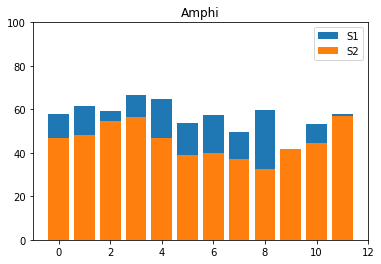

In [5]:
CourbeResume('Amphi')

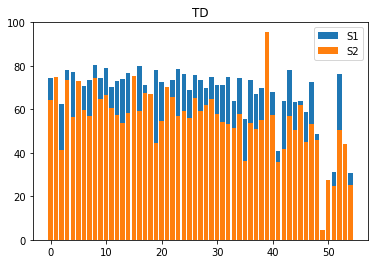

In [6]:
CourbeResume('TD')

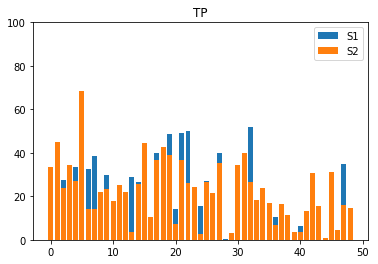

In [7]:
CourbeResume('TP')

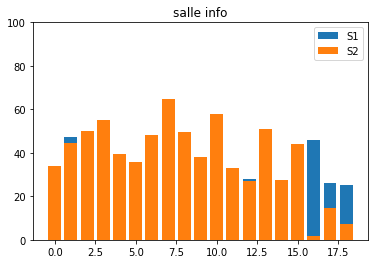

In [8]:
CourbeResume('salle info')

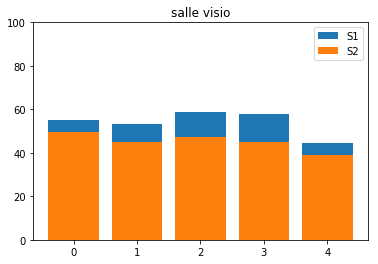

In [9]:
CourbeResume('salle visio')

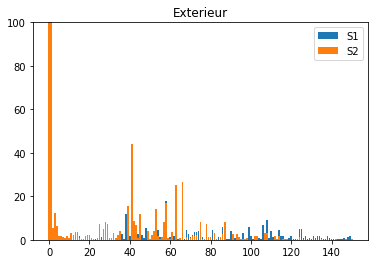

In [10]:
CourbeResume('Exterieur')

## Vision précise par salle et par créneau de la journée

In [11]:
CourbeJournee('Amphi')

interactive(children=(Dropdown(description='Amphi : ', options=('Amphi 111-Vidéo (Bât 26- RdC)', 'Amphi 112-vi…

In [12]:
CourbeJournee('TD')

interactive(children=(Dropdown(description='TD : ', options=('sa TD 006 PECB-sans vidéo (Bât 5)', 'sa TD 01 (B…

In [13]:
CourbeJournee('TP')

interactive(children=(Dropdown(description='TP : ', options=('sa TP 33Géol (Bât 14)', 'sa TP 34Geol-vidéo (Bât…

#### CourbeJournee('salle info')

In [14]:
CourbeJournee('salle visio')

interactive(children=(Dropdown(description='salle visio : ', options=('salle visio 204/Badge (Bât 26- 1er ét.)…

In [15]:
CourbeJournee('Exterieur')

interactive(children=(Dropdown(description='Exterieur : ', options=('[Exterieur] 01 (LV)', '[Exterieur] 015 (L…

In [16]:
# Un affichage textuel des matières et des groupes qui utilisent les salles de TP (non exploité et non exécuté)
"""
for s in NbHeuresS2['TP']:
    print(s)
    print("----- Matières ------")
    print(Matieres.get(s))
    print("----- Groupes  ------")
    print(Groupes.get(s))
    print("---------------------")
"""

'\nfor s in NbHeuresS2[\'TP\']:\n    print(s)\n    print("----- Matières ------")\n    print(Matieres.get(s))\n    print("----- Groupes  ------")\n    print(Groupes.get(s))\n    print("---------------------")\n'

## Informations complémentaires

### En complément, les salles de TD et TP sous exploitées

In [17]:
Exploitation('TD',sem="all",ub=50)

,Occupation S1,Occupation S2
sa TD 006 PECB-sans vidéo (Bât 5),40.70,35.64
sa TD B (Bât 1-Admin),48.42,45.80
sa TD 119-Manuf.Projets (Bât 26- RdC),0.25,4.58
sa TD 110- sans vidéo (Bât 26- RdC),26.18,27.37
sa TD U1-Studio Crs/Badge (Bât 2),31.05,24.55
sa TD 48 (Bât 14),37.88,43.94
sa TD 30-sans vidéo (Bât 5),30.76,25.28


In [18]:
Exploitation('TP',sem="all",ub=10)

,Occupation S1,Occupation S2
salle TP Projets L1-L2 (Bât 13),0.57,0.00
sa TP 33Géol (Bât 14),0.25,3.07
sa TP Thermo 35bis (Bât 14),1.53,3.81
sa TP Thermo 38bis (Bât 14),6.15,3.81
sa TP Phys 50 (Bât 14),0.00,0.76
sa TP Optoélectr 55 (Bât 14),0.00,4.61


## Vision précise par salle et par créneau de la journée (tout en un)

In [19]:
# CourbeJourneeLong('Amphi')

In [20]:
# CourbeJourneeLong('TD')

In [21]:
# CourbeJourneeLong('TP')

In [22]:
# CourbeJourneeLong('salle info')

In [23]:
# CourbeJourneeLong('salle visio')

In [24]:
# CourbeJourneeLong('Exterieur')

## Matières et groupes qui utilisent une salle donnée

In [25]:
Informations("Amphi")

interactive(children=(Dropdown(description='Amphi : ', options=('Amphi 111-Vidéo (Bât 26- RdC)', 'Amphi 112-vi…

In [26]:
Informations("TD")

interactive(children=(Dropdown(description='TD : ', options=('sa TD 006 PECB-sans vidéo (Bât 5)', 'sa TD 01 (B…

In [27]:
Informations("TP")

interactive(children=(Dropdown(description='TP : ', options=('sa TP 33Géol (Bât 14)', 'sa TP 34Geol-vidéo (Bât…

In [28]:
Informations("salle info")

interactive(children=(Dropdown(description='salle info : ', options=('salle info 1-vidéo/badge (Bât 2)', 'sall…

In [29]:
Informations('salle visio')

interactive(children=(Dropdown(description='salle visio : ', options=('salle visio 204/Badge (Bât 26- 1er ét.)…

In [30]:
Informations("Exterieur")

interactive(children=(Dropdown(description='Exterieur : ', options=('[Exterieur] 01 (LV)', '[Exterieur] 015 (L…

## Génération des calendriers

In [31]:
# TousCalendriers()